In [1]:
import json
from pathlib import Path

import biopsykit as bp
import matplotlib.pyplot as plt
import pandas as pd
import pingouin as pg
import seaborn as sns
import spm1d.stats.c
from biopsykit.questionnaires.utils import compute_scores, wide_to_long
from biopsykit.utils.dataframe_handling import convert_nan
from fau_colors import cmaps, register_fausans_font
import spm1d
from stressgait_analysis.dataset import StressGaitDataset


%matplotlib widget
%load_ext autoreload
%autoreload 2




import warnings
warnings.simplefilter(action='ignore')
import numpy as np

In [2]:
plt.close("all")

palette = sns.color_palette(cmaps.faculties_light)
sns.set_theme(context="notebook", style="ticks", font="sans-serif", palette=palette)

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["mathtext.default"] = "regular"
plt.rcParams["font.family"] = "sans-serif"
#plt.rcParams["font.sans-serif"] = "FAUSans Office"

palette

[(0.37254901960784315, 0.48627450980392156, 0.6392156862745098),
 (0.6666666666666666, 0.7647058823529411, 0.8196078431372549),
 (1.0, 0.8235294117647058, 0.44313725490196076),
 (0.37254901960784315, 0.7725490196078432, 0.9254901960784314),
 (0.5372549019607843, 0.803921568627451, 0.4745098039215686),
 (0.8627450980392157, 0.4117647058823529, 0.48627450980392156)]

In [3]:
deploy_type = "local"

config_dict = json.load(Path("../../config.json").open(encoding="utf-8"))

base_path = Path(config_dict[deploy_type]["base_path"])
gait_data_path = Path(config_dict[deploy_type]["gait_data_path"])

export_path = Path("../../exports")
plot_path = export_path.joinpath("plots")
bp.utils.file_handling.mkdirs([export_path, plot_path])

export_path

PosixPath('../../exports')

In [4]:
dataset = StressGaitDataset(base_path, coarse_condition=True, gait_data_path=gait_data_path, specify_bouts=True, specify_speed=True)


# Gait variability between strides

compute with coefficient of variation based on Winter, 2009

In [55]:
kinematics = dataset.kinematics.droplevel(level="bout")

In [56]:
bad_cycles = kinematics[kinematics['elbow_angle']<20].index.droplevel('percentage_of_stride').drop_duplicates()
# Step 2: Filter out those cycles
kinematics = kinematics[~kinematics.index.droplevel('percentage_of_stride').isin(bad_cycles)]
kinematics

hip_flexion  \
participant condition speed cycle_idx percentage_of_stride                
VP_01       omc       slow  0         0                       15.617907   
                                      1                       14.898942   
                                      2                       14.222986   
                                      3                       13.644998   
                                      4                       13.199635   
...                                                                 ...   
VP_47       omc       fast  200       96                      19.179123   
                                      97                      19.724742   
                                      98                      20.170698   
                                      99                      20.258313   
                                      100                     20.283606   

                                                            knee_flexion  \
participant condition speed cycle_idx percentage_of_stride                 
VP_01       omc       slow  0         0                         5.708224   
                                      1                         5.079829   
                                      2                         4.740407   
                                      3                         5.059201   
                                      4                         5.675398   
...                                                                  ...   
VP_47       omc       fast  200       96                       13.579015   
                                      97                       11.883767   
                                      98                       10.334821   
                                      99                        9.310462   
                                      100                       8.377337   

                                                            elbow_angle  \
participant condition speed cycle_idx percentage_of_stride                
VP_01       omc       slow  0         0                      175.770471   
                                      1                      176.342514   
                                      2                      176.848315   
                                      3                      177.203232   
                                      4                      177.406398   
...                                                                 ...   
VP_47       omc       fast  200       96                     168.330404   
                                      97                     168.646740   
                                      98                     168.890194   
                                      99                     168.931013   
                                      100                    168.936592   

                                                            shoulder_angle  \
participant condition speed cycle_idx percentage_of_stride                   
VP_01       omc       slow  0         0                         166.130160   
                                      1                         166.070783   
                                      2                         166.060716   
                                      3                         166.162965   
                                      4                         166.346609   
...                                                                    ...   
VP_47       omc       fast  200       96                        165.849253   
                                      97                        165.173631   
                                      98                        164.554919   
                                      99                        163.996690   
                                      100                       163.448979   

                                                            arm_swing  
participant condition speed cycl

In [57]:
def compute_cv(trial):

    std_trial = trial.groupby(["percentage_of_stride"]).std()
    mean_trial = trial.groupby(["percentage_of_stride"]).mean()

    mean_std_squared = std_trial.pow(2).mean()
    return np.sqrt(mean_std_squared) / mean_trial.mean()


In [58]:
cv = kinematics.groupby(["participant", "condition", "speed"]).apply(compute_cv)
cv_per_person = cv.groupby(["participant", "condition"]).mean()

In [59]:
cv_per_group = cv_per_person.groupby(["condition"]).mean()
cv_per_group

,hip_flexion,knee_flexion,elbow_angle,shoulder_angle,arm_swing
condition,,,,,
control,1.308371,0.123567,0.060796,0.03142,0.480295
omc,0.875980,0.133140,0.029338,0.02193,0.373519


In [60]:
df_long = cv_per_person.reset_index().melt(
    id_vars=["participant", "condition"],  # Keep these columns
    var_name="angle",  # Name for the melted variable column
    value_name="value"  # Name for the melted value column
)

df_long

,participant,condition,angle,value
0,VP_01,omc,hip_flexion,0.265311
1,VP_02,control,hip_flexion,0.177644
2,VP_05,control,hip_flexion,1.751908
3,VP_06,omc,hip_flexion,0.562728
4,VP_07,control,hip_flexion,0.428379
...,...,...,...,...
195,VP_43,omc,arm_swing,0.176200
196,VP_44,omc,arm_swing,0.322324
197,VP_45,omc,arm_swing,0.385160
198,VP_46,control,arm_swing,0.711786


<Axes: xlabel='angle', ylabel='value'>

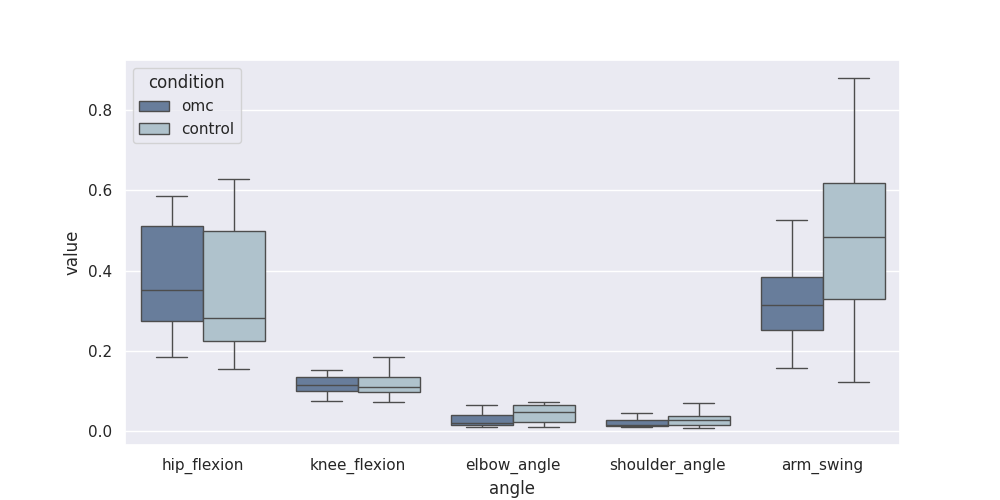

In [61]:
plt.figure()
sns.boxplot(x="angle", y="value", hue="condition", data=df_long,showfliers=False)

In [62]:
from scipy.stats import shapiro

# Apply Shapiro-Wilk test to each angle column, grouped by condition
normality_results = df_long.groupby(['condition', "angle"], group_keys=False)["value"].apply(lambda g: pg.normality(g))
normality_results

W          pval  normal
control arm_swing       0.982129  9.585305e-01    True
        elbow_angle     0.752496  1.833937e-04   False
        hip_flexion     0.468288  1.663085e-07   False
        knee_flexion    0.774093  3.639056e-04   False
        shoulder_angle  0.836176  3.154215e-03   False
omc     arm_swing       0.739204  1.220781e-04   False
        elbow_angle     0.857645  7.178506e-03   False
        hip_flexion     0.538739  7.268207e-07   False
        knee_flexion    0.750164  1.706262e-04   False
        shoulder_angle  0.814188  1.417364e-03   False

In [63]:
test_results = df_long.groupby(["angle"], group_keys=False).apply(lambda g: pg.pairwise_tests(g, parametric=False, dv = "value", between="condition"))
test_results["p_corr"] = test_results["p-unc"]*len(df_long.angle.unique())
test_results["p_corr"].clip(upper=1, inplace=True)
test_results

,Contrast,A,B,Paired,Parametric,U-val,alternative,p-unc,hedges,p_corr
0,condition,control,omc,False,False,270.0,two-sided,0.060111,0.476354,0.300553
0,condition,control,omc,False,False,278.0,two-sided,0.036048,0.727128,0.180242
0,condition,control,omc,False,False,167.0,two-sided,0.379332,0.188395,1.000000
0,condition,control,omc,False,False,189.0,two-sided,0.776391,-0.164755,1.000000
0,condition,control,omc,False,False,262.0,two-sided,0.096196,0.543845,0.480981


within - stride - variance


In [70]:


def rom(trial):
    max = trial.groupby(["cycle_idx"]).max()
    min = trial.groupby(["cycle_idx"]).min()


    return np.mean(max - min, axis=0)


var_within = kinematics.groupby(["participant", "condition", "speed"]).apply(rom)
var_per_person = var_within.groupby(["participant", "condition"]).mean().loc[:,["elbow_angle", "shoulder_angle", "arm_swing"]]

var_per_group = var_per_person.groupby(["condition"]).mean()
var_per_group

,elbow_angle,shoulder_angle,arm_swing
condition,,,
control,21.104126,25.157917,116.987767
omc,19.277945,26.132404,119.759898


<Axes: xlabel='angle', ylabel='value'>

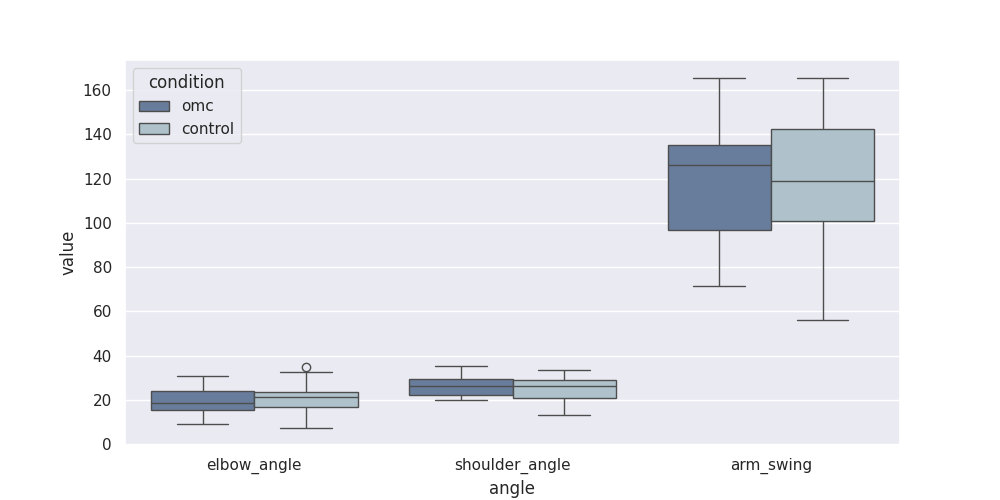

In [71]:
df_long = var_per_person.reset_index().melt(
    id_vars=["participant", "condition"],  # Keep these columns
    var_name="angle",  # Name for the melted variable column
    value_name="value"  # Name for the melted value column
)
plt.figure()
sns.boxplot(x="angle", y="value", hue="condition", data=df_long, showfliers=True)

In [72]:
normality_results = df_long.groupby(['condition', "angle"], group_keys=False)["value"].apply(lambda g: pg.normality(g))
normality_results

W      pval  normal
control arm_swing       0.960699  0.557914    True
        elbow_angle     0.964636  0.639977    True
        shoulder_angle  0.939897  0.238710    True
omc     arm_swing       0.959581  0.535520    True
        elbow_angle     0.962563  0.596224    True
        shoulder_angle  0.945672  0.306116    True

In [74]:
test_results = df_long.groupby(["angle"], group_keys=False).apply(lambda g: pg.pairwise_tests(g, parametric=True, dv = "value", between="condition"))
test_results["p_corr"] = test_results["p-unc"]*len(df_long.angle.unique())
test_results["p_corr"].clip(upper=1, inplace=True)
test_results

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges,p_corr
0,condition,control,omc,False,True,-0.301537,38.0,two-sided,0.764649,0.32,-0.093460,1.0
0,condition,control,omc,False,True,0.963041,38.0,two-sided,0.341616,0.446,0.298490,1.0
0,condition,control,omc,False,True,-0.598597,38.0,two-sided,0.552993,0.356,-0.185532,1.0
